## Import necessary packages:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from functools import partial
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import average_precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression

seed = 0

Probe = ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan']

DoS = ['apache2', 'back', 'land', 'mailbomb', 'neptune', 'pod', 'processtable', 'smurf', 'teardrop', 'udpstorm']

R2L = ['buffer_overflow', 'httptunnel', 'loadmodule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm']

U2R = ['ftp_write', 'guess_passwd', 'imap', 'multihop', 'named', 'phf', 'sendmail', 'snmpgetattack', 'snmpguess',
       'spy', 'warezclient', 'warezmaster', 'worm', 'xlock', 'xsnoop']

## Import data and assign feature name to each column:

In [2]:
columns = []
with open('kddcup.names') as f:
    next(f)
    for line in f:
        feature = line.split(':')[0]
        columns.append(feature)
columns.append('label')

In [3]:
train_data = pd.read_csv('kddcup.data', header=None)
train_data.columns = columns
train_data['label'] = train_data['label'].apply(lambda x: x.replace('.', ''))

test_data = pd.read_csv('corrected', header=None)
test_data.columns = columns
test_data['label'] = test_data['label'].apply(lambda x: x.replace('.', ''))

In [4]:
boundary = train_data.shape[0]
whole_data = pd.concat([train_data, test_data], axis=0)

## One-hot encoding:

In [5]:
categorical = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login']
whole_data_categorical = whole_data[categorical].copy()
whole_data.drop(columns=categorical, inplace=True)
whole_data_categorical_T = pd.get_dummies(whole_data_categorical)
num_one_hot_features = whole_data_categorical_T.shape[1]
display(num_one_hot_features)
whole_data = pd.concat([whole_data_categorical_T, whole_data], axis=1)

89

## Split data into training and test set:

In [6]:
train_data = whole_data.iloc[:boundary]
test_data = whole_data.iloc[boundary:]

X_train, y_train = train_data.drop(columns='label'), train_data['label']
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=seed)
X_test, y_test = test_data.drop(columns='label'), test_data['label']

## Convert specific attack types to four general attack types in y_valid and y_test:

In [ ]:
for attack in Probe:
    y_valid = y_valid.replace(attack, 'Probe')
    y_test = y_test.replace(attack, 'Probe')
    
for attack in DoS:
    y_valid = y_valid.replace(attack, 'DoS')
    y_test = y_test.replace(attack, 'DoS')
    
for attack in R2L:
    y_valid = y_valid.replace(attack, 'R2L')
    y_test = y_test.replace(attack, 'R2L')
    
for attack in U2R:
    y_valid = y_valid.replace(attack, 'U2R')
    y_test = y_test.replace(attack, 'U2R')

## Store preprocessed data for later usage:

In [16]:
X_train.to_pickle("X_train.pkl")
y_train.to_pickle("y_train.pkl")

X_valid.to_pickle("X_valid.pkl")
y_valid.to_pickle("y_valid.pkl")

X_test.to_pickle("X_test.pkl")
y_test.to_pickle("y_test.pkl")

## Load preprocessed data back:

In [2]:
X_train = pd.read_pickle("X_train.pkl")
y_train = pd.read_pickle("y_train.pkl")

X_valid = pd.read_pickle("X_valid.pkl")
y_valid = pd.read_pickle("y_valid.pkl")

X_test = pd.read_pickle("X_test.pkl")
y_test = pd.read_pickle("y_test.pkl")

num_one_hot_features = 89

## Sample a subset of training data from the original training set:

In [3]:
# Recombine X_train and y_train into a dataframe:
X_train_df = pd.concat([X_train, y_train], axis=1)

In [4]:
# Divide instances by label:
label_list = np.unique(X_train_df['label'])

df_label_list_dict = {'Probe': [], 'DoS': [], 'R2L': [], 'U2R': [], 'normal': []}
for label in label_list:
    df_label = X_train_df[X_train_df['label'] == label]
    
    if label in Probe:
        df_label_list_dict['Probe'].append(df_label)
    elif label in DoS:
        df_label_list_dict['DoS'].append(df_label)
    elif label in R2L:
        df_label_list_dict['R2L'].append(df_label)
    elif label in U2R:
        df_label_list_dict['U2R'].append(df_label)
    else:
        df_label_list_dict['normal'].append(df_label)

In [5]:
# Determine the maximum number of instances to be sampled from each label:
num_samples_per_label = 500

X_train_df_sampled = pd.DataFrame()
sample_weights = []

for cls, df_label_list in df_label_list_dict.items():
    sample_distribution_within_cls = []
    
    for df_label in df_label_list:
        num_instances = df_label.shape[0]
        num_samples = min(num_instances, num_samples_per_label)
        
        sample_distribution_within_cls.append(num_samples)
        df_sampled = df_label.sample(n=num_samples, random_state=seed)
        X_train_df_sampled = pd.concat([X_train_df_sampled, df_sampled], axis=0)
        
    sample_distribution_within_cls = np.array(sample_distribution_within_cls)
    weight_per_sample_group = sample_distribution_within_cls.sum() / sample_distribution_within_cls
    
    for i in range(len(sample_distribution_within_cls)):
        sample_weights += [weight_per_sample_group[i]] * sample_distribution_within_cls[i]

In [6]:
# Decompose X_train_df_sampled into X_train and y_train again:
X_train, y_train = X_train_df_sampled.drop(columns='label'), X_train_df_sampled['label']

## Convert specific attack types to four general attack types in y_train:

In [7]:
for attack in Probe:
    y_train = y_train.replace(attack, 'Probe')
    
for attack in DoS:
    y_train = y_train.replace(attack, 'DoS')
    
for attack in R2L:
    y_train = y_train.replace(attack, 'R2L')
    
for attack in U2R:
    y_train = y_train.replace(attack, 'U2R')

## Use mutual information to perform feature selection:

In [8]:
# Obtain feature index for categorical features:
categorical_idx = [i for i in range(num_one_hot_features)]
mutual_info_scores = mutual_info_classif(X_train, y_train, discrete_features=categorical_idx)

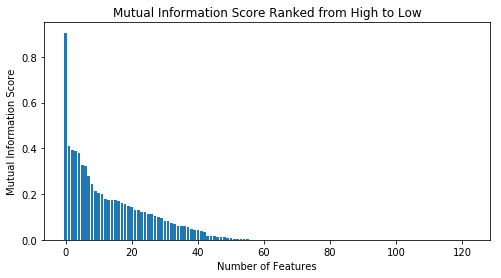

In [9]:
# Plot mutual information scores from high to low:
x = np.arange(len(X_train.columns))

plt.figure(figsize=(8, 4))
plt.bar(x, -np.sort(-mutual_info_scores))
plt.xlabel('Number of Features')
plt.ylabel('Mutual Information Score')
plt.title('Mutual Information Score Ranked from High to Low')
plt.show()

In [10]:
# Code to show what are the top features:
num_selected_features = 10
idx_best_features = np.sort((-mutual_info_scores).argsort()[:num_selected_features])
selected_features = list(X_train_df.columns[idx_best_features])
display(selected_features)

['logged_in',
 'src_bytes',
 'dst_bytes',
 'count',
 'srv_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_srv_rerror_rate']

## Visualization of Feature:

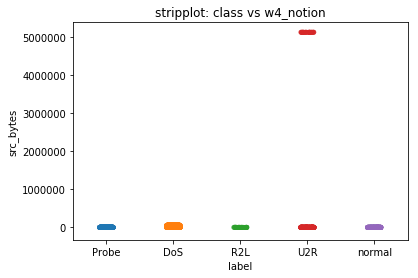

In [20]:
X_train_df = pd.concat([X_train, y_train], axis=1)
ax = sns.stripplot(x='label', y='src_bytes', data=X_train_df, jitter=True, alpha=0.7)
plt.title('stripplot: class vs w4_notion')
plt.show()

In [11]:
k_selected_features = [10]

## Standardize feature vectors using StandardScaler:

In [12]:
sscaler = preprocessing.StandardScaler().fit(X_train)
X_train, X_valid, X_test = sscaler.transform(X_train), sscaler.transform(X_valid), sscaler.transform(X_test)

/anaconda3/envs/dme/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/dme/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  
/anaconda3/envs/dme/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  
/anaconda3/envs/dme/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


## Stratified holdout validation:

In [13]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)

## Stratified Cross Validation:

In [14]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

## Make custom scorers for grid search:

In [15]:
def prob_avg_PR_scorer(clf, X, y):
    y_pred = clf.predict_proba(X)
    return average_precision_score(preprocessing.LabelBinarizer().fit_transform(y), y_pred, average='macro')

def deci_avg_PR_scorer(clf, X, y):
    y_pred = clf.decision_function(X)
    return average_precision_score(preprocessing.LabelBinarizer().fit_transform(y), y_pred, average='macro')

## Softmax Regression for multinomial classification:
### Linear decision boundary:

In [16]:
k_best = SelectKBest(score_func=partial(mutual_info_classif, random_state=seed))
pipeline = Pipeline(steps=[('k_best', k_best), ('lgr', LogisticRegression(multi_class='multinomial', class_weight='balanced', solver='lbfgs'))])

parameters = {
    'k_best__k': k_selected_features,
    'lgr__C': np.logspace(-5, 5, 10)
}

gs_lgr = GridSearchCV(pipeline, parameters, prob_avg_PR_scorer, cv=skf)
gs_lgr.fit(X_train, y_train, sample_weights)
lgr = gs_lgr.best_estimator_

# Multiclass macro average PR_AUC:
avg_PR = prob_avg_PR_scorer(lgr, X_valid, y_valid)

print ("The best average PR_AUC for Logistic Regression on validation set is {:.4f}".format(avg_PR))
display(gs_lgr.best_params_)

/anaconda3/envs/dme/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/dme/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/dme/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/dme/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/dme/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

The best average PR_AUC for Logistic Regression on validation set is 0.5764


{'k_best__k': 10, 'lgr__C': 599.4842503189421}

## Plot confusion matrix of Softmax Regression on validation set:

In [17]:
y_pred_valid = lgr.predict(X_valid)
cm = confusion_matrix(y_valid, y_pred_valid)
cm = pd.DataFrame(data=cm, index=[lgr.classes_], columns=[lgr.classes_])

In [18]:
percent_correct_horizontal = cm.sum(axis=1)
for i in range(cm.shape[0]):
    percent_correct_horizontal.iloc[i] = cm.iloc[i, i] / percent_correct_horizontal.iloc[i]
percent_correct_horizontal = round(percent_correct_horizontal * 100, 2)
percent_correct_horizontal = percent_correct_horizontal.apply(lambda x: str(x) + '%')

In [19]:
percent_correct_vertical = cm.sum(axis=0)
for i in range(cm.shape[0]):
    percent_correct_vertical.iloc[i] = cm.iloc[i, i] / percent_correct_vertical.iloc[i]
percent_correct_vertical = round(percent_correct_vertical * 100, 2)
percent_correct_vertical = percent_correct_vertical.apply(lambda x: str(x) + '%')

In [20]:
cm['Recall%'] = percent_correct_horizontal
percent_correct_vertical.name = ('Precision%', 5)
cm = cm.append(percent_correct_vertical)
display(cm)

,DoS,Probe,R2L,U2R,normal,Recall%
DoS,775886,94,248,117,330,99.9%
Probe,384,7630,51,106,49,92.82%
R2L,0,0,9,2,0,81.82%
U2R,0,1,69,144,11,64.0%
normal,9031,13403,3416,11834,156872,80.63%
Precision%,98.8%,36.11%,0.24%,1.18%,99.75%,NaN


## SVM with radial basis function (rbf) kernel for OvR multiclass classification:
### Non-linear decision boundary:

In [ ]:
k_best = SelectKBest(score_func=partial(mutual_info_classif, random_state=seed))
pipeline = Pipeline(steps=[('k_best', k_best), ('svm_rbf', SVC(kernel='rbf', decision_function_shape='ovr', class_weight='balanced'))])

parameters = {
    'k_best__k': k_selected_features,
    'svm_rbf__C': np.logspace(-5, 5, 10),
    'svm_rbf__gamma': np.logspace(-5, 0, 5)
}

gs_svm_rbf = GridSearchCV(pipeline, parameters, deci_avg_PR_scorer, cv=skf)
gs_svm_rbf.fit(X_train, y_train, sample_weights)
svm_rbf = gs_svm_rbf.best_estimator_

# Multiclass macro average PR_AUC:
avg_PR = deci_avg_PR_scorer(svm_rbf, X_valid, y_valid)

print ("The best average PR_AUC for Support Vector Machine with rbf kernel on validation set is {:.4f}".format(avg_PR))
display(gs_svm_rbf.best_params_)

## Plot confusion matrix of SVM on validation set:

In [ ]:
y_pred_valid = svm_rbf.predict(X_valid)
cm = confusion_matrix(y_valid, y_pred_valid)
cm = pd.DataFrame(data=cm, index=[svm_rbf.classes_], columns=[svm_rbf.classes_])

In [ ]:
percent_correct_horizontal = cm.sum(axis=1)
for i in range(cm.shape[0]):
    percent_correct_horizontal.iloc[i] = cm.iloc[i, i] / percent_correct_horizontal.iloc[i]
percent_correct_horizontal = round(percent_correct_horizontal * 100, 2)
percent_correct_horizontal = percent_correct_horizontal.apply(lambda x: str(x) + '%')

In [ ]:
percent_correct_vertical = cm.sum(axis=0)
for i in range(cm.shape[0]):
    percent_correct_vertical.iloc[i] = cm.iloc[i, i] / percent_correct_vertical.iloc[i]
percent_correct_vertical = round(percent_correct_vertical * 100, 2)
percent_correct_vertical = percent_correct_vertical.apply(lambda x: str(x) + '%')

In [ ]:
cm['Recall%'] = percent_correct_horizontal
percent_correct_vertical.name = ('Precision%', 5)
cm = cm.append(percent_correct_vertical)
display(cm)